In [515]:
import os
import pandas as pd
import os.path as osp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Load files

In [516]:
os.getcwd()

'D:\\Project- Electro\\social_behavior_electro\\data_organization\\python'

In [517]:
folder_path = osp.join('..','..','analysis')
path_to_aversive_enc_pre = osp.join(folder_path,
                            'Population analysis results for LFP Coherence - Encounter-PreEncounter_4-12_30-80_aversive.xlsx')
path_to_affiliative_enc_pre = osp.join(folder_path,
                               'Population analysis results for LFP Coherence - Encounter-PreEncounter_4-12_30-80_affiliative.xlsx')

path_to_aversive_post_pre = osp.join(folder_path,
                            'Population analysis results for LFP Coherence - PostEncounter-PreEncounter_4-12_30-80_aversive.xlsx')
path_to_affiliative_post_pre = osp.join(folder_path,
                               'Population analysis results for LFP Coherence - PostEncounter-PreEncounter_4-12_30-80_affiliative.xlsx')



path_to_affiliative_lfp = osp.join(folder_path,
                            'lfp_rawdata_affiliative.xlsx') 

path_to_aversive_lfp = osp.join(folder_path,
                            'lfp_rawdata_aversive.xlsx')

path_to_common_areas = osp.join(folder_path, 'common_area_pairs_w5_sessions.xlsx')



In [556]:
df_aff_lfp_raw = pd.read_excel(path_to_affiliative_lfp ,header=[0,1,2], index_col=[0])
df_avv_lfp_raw = pd.read_excel(path_to_aversive_lfp ,header=[0,1,2], index_col=[0])

In [484]:
df_aff_enc_pre = pd.read_excel(path_to_affiliative_enc_pre,None)
df_avv_enc_pre = pd.read_excel(path_to_aversive_enc_pre,None)

df_aff_post_pre = pd.read_excel(path_to_affiliative_post_pre,None)
df_avv_post_pre = pd.read_excel(path_to_aversive_post_pre,None)


df_files_avv_bad = pd.read_excel(path_to_aversive_enc_pre,'Uploaded files', header=None)
df_files_aff_bad = pd.read_excel(path_to_affiliative_enc_pre,'Uploaded files', header=None)

df_areas = pd.read_excel(path_to_common_areas)


## Clean and combine data

In [485]:
def fix_file_paths(df_files):
    
    df_files = df_files.rename(columns={df_files.columns[0]:'timestamps', df_files.columns[0]:'lfp', })
    
    return df_files
df_files_avv = fix_file_paths(df_files_avv_bad)['lfp']
df_files_aff = fix_file_paths(df_files_aff_bad)['lfp']


In [549]:
area_num_to_name_map = {
    111: 'MeA',
    2: 'MePV',
    13:'CeA',
    112: 'BMA',
    14: 'AA',
    16: 'EA',
    12: 'STIA',
    15: 'VP'
}

def reformat_columns(df):
    # combine column names and remove levels
    df_new = pd.DataFrame()
    areas = df.columns.get_level_values('area').unique()
    freqs = df.columns.get_level_values('freq').unique()
    stages = df.columns.get_level_values('stage').unique()

    df_new.index = df.index
    for area in areas:
        for freq in freqs:
            for stage in stages:

                col_name = (area, freq, stage)
                new_col_name = '_'.join(col_name)

                df_new[new_col_name] = df[col_name]
    return df_new

In [557]:
df_aff_lfp = reformat_columns(df_aff_lfp_raw)
df_aff_lfp['sociability'] = 'affiliative'

df_avv_lfp = reformat_columns(df_avv_lfp_raw)
df_avv_lfp['sociability'] = 'aversive'

In [551]:
# Add variables befor concatination
df_aff_enc_pre = pd.read_excel(path_to_affiliative_enc_pre,None)
# df_aff_enc_pre['sociability'] = 'affiliative'
# df_aff_enc_pre['stage'] = 'enc_pre'

df_aff_post_pre = pd.read_excel(path_to_affiliative_post_pre,None)
# df_aff_post_pre['sociability'] = 'affiliative'
# df_aff_post_pre['stage'] = 'post_pre'


df_avv_enc_pre = pd.read_excel(path_to_aversive_enc_pre,None)
# df_avv_enc_pre['sociability'] = 'aversive'
# df_avv_enc_pre['stage'] = 'enc_pre'


df_avv_post_pre = pd.read_excel(path_to_aversive_post_pre,None)
# df_avv_post_pre['sociability'] = 'aversive'
# df_avv_post_pre['stage'] = 'post_pre'



In [558]:
freq_keywords = {'First': '4_18Hz', 'Second':'30_80Hz'}
stage_keywords = {'During':'enc_pre', 'After':'post_pre'}
substrings_to_remove = ['During', 'After','Before', 'First', 'Second']
ignore_keyworks = ['Norm', 'files']

def remove_columns_with_fewer_values(df, N=5):
    # Get the count of non-null values in each column
    column_counts = df.count()

    # Filter columns based on count condition
    columns_to_remove = column_counts[column_counts < N].index

    # Drop the columns from the DataFrame
    updated_df = df.drop(columns=columns_to_remove)

    return updated_df

def reformat_dict_to_table(df_dict, file_df):
# def reformat_dict_to_table(df_dict, freq_keywords, stage_keywords, ignore_keyworks, substrings_to_remove):
    ret_df_list = []
    for sheet, df in df_dict.items():
        df = df.copy()
        # ignore first and last sheets that contain a summary and list of file names
        if any(substring in sheet for substring in ignore_keyworks): 
            continue
            
        if isinstance(df, str):
            print(df)
            continue
            
        if len(df) == 0:
            continue
        
         # Remove all substrings to keep just the area name
        area_name = sheet
        for sub_string_to_remove in substrings_to_remove:
            area_name = area_name.replace(sub_string_to_remove,'')
        
        for fk, freq in  freq_keywords.items():
            if fk in sheet:
                this_freq = freq_keywords[fk]
            for sk in stage_keywords.keys():
                if sk in sheet:
                    this_stage = stage_keywords[sk]
        
                # Rename all column names to match
        
        for col in df.columns:
            area_pair = [col, area_name]
            area_pair.sort()
            
            df.rename(columns={col:f'{area_pair[0]}_{area_pair[1]}_{this_freq}_{this_stage}'}, inplace=True)
        
        
        df.dropna(axis=1, how='all', inplace=True)
        df = remove_columns_with_fewer_values(df)
        ret_df_list.append(df)
        
    df_ret = pd.concat(ret_df_list,axis=1)
    df_ret['files'] = file_df.values
    return df_ret
                
            



In [559]:
df_aff_enc_pre_rectified = reformat_dict_to_table(df_aff_enc_pre, df_files_aff)
df_aff_enc_post_rectified = reformat_dict_to_table(df_aff_post_pre, df_files_aff)
df_aff = pd.concat([df_aff_enc_pre_rectified.drop('files', axis=1), df_aff_enc_post_rectified], axis=1)
df_aff['sociability'] = 'affiliative'

df_avv_enc_pre_rectified = reformat_dict_to_table(df_avv_enc_pre, df_files_avv)
df_avv_enc_post_rectified = reformat_dict_to_table(df_avv_post_pre, df_files_avv)
df_avv = pd.concat([df_avv_enc_pre_rectified.drop('files', axis=1), df_avv_enc_post_rectified], axis=1)
df_avv['sociability'] = 'aversive'


In [560]:
df_avv_cols = df_avv.columns
df_aff_cols = df_aff.columns
common_cols = set(df_aff_cols).intersection(set(df_avv_cols))
df_aff = df_aff[common_cols]
df_avv = df_avv[common_cols]


In [555]:
all_df = pd.concat([df_aff, df_avv])
all_df = all_df.set_index('files')
# all_df.to_excel(osp.join(folder_path, 'combined_data.xlsx'))

In [561]:
all_df.columns

Index(['BMA_MeD_30_80Hz_enc_pre', 'sociability', 'BMA_MeD_4_18Hz_enc_pre',
       'AA_BMA_4_18Hz_enc_pre', 'CeA_MeD_4_18Hz_enc_pre',
       'CeA_STIA_30_80Hz_post_pre', 'BMA_MePV_30_80Hz_enc_pre',
       'BMA_MeD_30_80Hz_post_pre', 'MeD_STIA_30_80Hz_enc_pre',
       'CeA_STIA_30_80Hz_enc_pre', 'MeD_STIA_4_18Hz_post_pre',
       'BMA_MePV_4_18Hz_post_pre', 'AA_MeD_30_80Hz_enc_pre',
       'AA_BMA_4_18Hz_post_pre', 'EA_MeD_30_80Hz_post_pre',
       'AA_BMA_30_80Hz_enc_pre', 'EA_MeD_4_18Hz_enc_pre',
       'BMA_MeD_4_18Hz_post_pre', 'CeA_STIA_4_18Hz_enc_pre',
       'CeA_STIA_4_18Hz_post_pre', 'AA_MeD_4_18Hz_post_pre',
       'BMA_MePV_30_80Hz_post_pre', 'EA_MeD_30_80Hz_enc_pre',
       'MeD_STIA_4_18Hz_enc_pre', 'AA_MeD_30_80Hz_post_pre',
       'CeA_MeD_30_80Hz_enc_pre', 'AA_BMA_30_80Hz_post_pre',
       'CeA_MeD_30_80Hz_post_pre', 'BMA_MePV_4_18Hz_enc_pre',
       'CeA_MeD_4_18Hz_post_pre', 'MeD_STIA_30_80Hz_post_pre',
       'EA_MeD_4_18Hz_post_pre', 'AA_MeD_4_18Hz_enc_pre'],
      dt

## Perform statistical analysis

In [492]:
from scipy.stats import mannwhitneyu
from sklearn.linear_model import LogisticRegression



In [493]:
all_df.columns

Index(['BMA_MeD_30_80Hz_enc_pre', 'sociability', 'BMA_MeD_4_18Hz_enc_pre',
       'AA_BMA_4_18Hz_enc_pre', 'CeA_MeD_4_18Hz_enc_pre',
       'CeA_STIA_30_80Hz_post_pre', 'BMA_MePV_30_80Hz_enc_pre',
       'BMA_MeD_30_80Hz_post_pre', 'MeD_STIA_30_80Hz_enc_pre',
       'CeA_STIA_30_80Hz_enc_pre', 'MeD_STIA_4_18Hz_post_pre',
       'BMA_MePV_4_18Hz_post_pre', 'AA_MeD_30_80Hz_enc_pre',
       'AA_BMA_4_18Hz_post_pre', 'EA_MeD_30_80Hz_post_pre',
       'AA_BMA_30_80Hz_enc_pre', 'EA_MeD_4_18Hz_enc_pre',
       'BMA_MeD_4_18Hz_post_pre', 'CeA_STIA_4_18Hz_enc_pre',
       'CeA_STIA_4_18Hz_post_pre', 'AA_MeD_4_18Hz_post_pre',
       'BMA_MePV_30_80Hz_post_pre', 'EA_MeD_30_80Hz_enc_pre',
       'MeD_STIA_4_18Hz_enc_pre', 'AA_MeD_30_80Hz_post_pre',
       'CeA_MeD_30_80Hz_enc_pre', 'AA_BMA_30_80Hz_post_pre',
       'CeA_MeD_30_80Hz_post_pre', 'BMA_MePV_4_18Hz_enc_pre',
       'CeA_MeD_4_18Hz_post_pre', 'MeD_STIA_30_80Hz_post_pre',
       'EA_MeD_4_18Hz_post_pre', 'AA_MeD_4_18Hz_enc_pre'],
      dt

In [494]:
# extract values

df_values = all_df.drop('sociability',axis=1)
y = all_df['sociability'].values

In [495]:
MIN_N_SESSIONS = 5

def variable_significance_table(df):
    significance_table = pd.DataFrame(columns=["Variable", "Statistic", "p-value"])

    predictor = df["sociability"]

    for column in df.columns:
        if column != "sociability":
            
            variable = df[column].values
            
            variable_aff = variable[np.where(predictor=='affiliative')]
            variable_avv = variable[np.where(predictor=='aversive')]
            
            
            variable_aff = variable_aff[~pd.isnull(variable_aff)]
            variable_avv = variable_avv[~pd.isnull(variable_avv)]
            
            if len(variable_aff)<MIN_N_SESSIONS or len(variable_avv)< MIN_N_SESSIONS:
                continue

            statistic, p_value = mannwhitneyu(variable_avv, variable_aff)

            significance_table = significance_table.append(
                {"Variable": column, "Statistic": statistic, "p-value": p_value},
                ignore_index=True
            )

    return significance_table


sig_table = variable_significance_table(df=all_df)
print(sig_table)


                     Variable  Statistic   p-value
0     BMA_MeD_30_80Hz_enc_pre       51.0  0.945211
1      BMA_MeD_4_18Hz_enc_pre       45.0  0.629796
2       AA_BMA_4_18Hz_enc_pre       23.0  0.177489
3      CeA_MeD_4_18Hz_enc_pre       60.0  0.024456
4   CeA_STIA_30_80Hz_post_pre       36.0  0.206460
5    BMA_MePV_30_80Hz_enc_pre       26.0  0.954645
6    BMA_MeD_30_80Hz_post_pre       49.0  0.836593
7    MeD_STIA_30_80Hz_enc_pre       23.0  0.661172
8    CeA_STIA_30_80Hz_enc_pre       41.0  0.055278
9    MeD_STIA_4_18Hz_post_pre       24.0  0.742674
10   BMA_MePV_4_18Hz_post_pre       34.0  0.455944
11     AA_MeD_30_80Hz_enc_pre      108.0  0.028108
12     AA_BMA_4_18Hz_post_pre       21.0  0.329004
13    EA_MeD_30_80Hz_post_pre       51.0  0.599878
14     AA_BMA_30_80Hz_enc_pre       20.0  0.428571
15      EA_MeD_4_18Hz_enc_pre       43.0  0.967849
16    BMA_MeD_4_18Hz_post_pre       41.0  0.447474
17    CeA_STIA_4_18Hz_enc_pre       33.0  0.370962
18   CeA_STIA_4_18Hz_post_pre  

In [496]:
# Significan columns:
sig_table = sig_table.loc[sig_table['p-value']<=0.05]

In [497]:
sig_table

,Variable,Statistic,p-value
3,CeA_MeD_4_18Hz_enc_pre,60.0,0.024456
11,AA_MeD_30_80Hz_enc_pre,108.0,0.028108
26,CeA_MeD_30_80Hz_post_pre,61.0,0.018207
31,AA_MeD_4_18Hz_enc_pre,110.0,0.020729


In [498]:
df_train

,CeA_MeD_4_18Hz_enc_pre,AA_MeD_30_80Hz_enc_pre,CeA_MeD_30_80Hz_post_pre,AA_MeD_4_18Hz_enc_pre,sociability,dataset
files,,,,,,
chamber_Rat3-probe2-sniffing-day2-Behavior_and_Optogenetics_TimeStamps_Probe_A.mat,-0.278337,NaN,-0.050001,NaN,affiliative,train
chamber_Rat3-Probe2-sniffing-Day3-Behavior_and_Optogenetics_TimeStamps_Probe_A.mat,-0.196929,NaN,-0.121309,NaN,affiliative,train
chamber_Rat15-probe17-day1-Behavior_and_Optogenetics_TimeStamps.mat,-0.131179,NaN,-0.005317,NaN,affiliative,train
chamber_Rat16-probe18-day3-Behavior_and_Optogenetics_TimeStamps.mat,NaN,-0.128517,NaN,-0.124539,affiliative,train
chamber_Rat19-probe18-Day2-Behavior_and_Optogenetics_TimeStamps.mat,NaN,-0.029703,NaN,-0.133070,affiliative,train
chamber_Rat19-Probe18-day3-Behavior_and_Optogenetics_TimeStamps.mat,NaN,-0.085707,NaN,-0.359844,affiliative,train
chamber_Rat19-probe18-day6-Behavior_and_Optogenetics_TimeStamps.mat,NaN,-0.051024,NaN,-0.227291,affiliative,train
chamber_Rat21-probe20-day1-Behavior_and_Optogenetics_TimeStamps.mat,NaN,-0.010271,NaN,-0.058165,affiliative,train
Chamber_Rat26-Probe25-Day1-Behavior_and_Optogenetics_TimeStamps.mat,NaN,-0.018101,NaN,-0.089558,affiliative,train


In [499]:
sig_df = all_df[sig_table['Variable']].copy()
all_data_flag = np.sum(np.invert(np.isnan(sig_df.values)), axis=1)
sig_df['sociability'] = all_df['sociability']
ind_train = np.logical_and(all_data_flag>0, all_data_flag<4)
ind_test = all_data_flag==4

In [500]:
df_train = sig_df.loc[ind_train].copy()
df_train['dataset'] = 'train'
df_test = sig_df.loc[ind_test].copy()
df_test['dataset'] = 'test'

df_dataset = pd.concat([df_train,df_test])
# df_dataset


In [501]:
# Check the destribution of classes
result = df_dataset.groupby(['dataset', 'sociability']).size().unstack('sociability')
print(result)

# transfere sessions of rat 19 from train to test
# transfere sessions of rat 23 from test to train
# transfere sessions of rat 4 from test to train
df_dataset.loc[df_dataset.index.str.contains('Rat23'),'dataset'] = 'train'
df_dataset.loc[df_dataset.index.str.contains('Rat4'),'dataset'] = 'train'
df_dataset.loc[df_dataset.index.str.contains('Rat19'),'dataset'] = 'test'

result = df_dataset.groupby(['dataset', 'sociability']).size().unstack('sociability')
print(result)

sociability  affiliative  aversive
dataset                           
test                   3         8
train                 10        10
sociability  affiliative  aversive
dataset                           
test                   4         6
train                  9        12


In [562]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
from sklearn.pipeline import Pipeline


############################
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

In [564]:
X_train = df_dataset.loc[df_dataset['dataset'] == 'train' ].drop(['sociability','dataset'], axis=1).values
y_train = df_dataset.loc[df_dataset['dataset'] == 'train' ]['sociability']

X_test = df_dataset.loc[df_dataset['dataset'] == 'test' ].drop(['sociability','dataset'], axis=1).values
y_test = df_dataset.loc[df_dataset['dataset'] == 'test' ]['sociability']



In [565]:
def eval_model(y_test, y_test_pred):
#     print(f'y:{y_test}')
#     print(f'y_pred:{y_test_pred}')
    # Calculating evaluation metrics on the testing set
    ret_accuracy = accuracy_score(y_test, y_test_pred)
    ret_precision = precision_score(y_test, y_test_pred, pos_label="affiliative")
    ret_recall = recall_score(y_test, y_test_pred,pos_label="affiliative")
    ret_f1 = f1_score(y_test, y_test_pred,pos_label="affiliative")
#     ret_roc_auc = roc_auc_score(y_test, y_test_pred)
    ret = {
        'accuracy':np.round(ret_accuracy, 3),
        'precision':np.round(ret_precision, 3),
        'recall':np.round(ret_recall, 3),
        'f1':np.round(ret_f1, 3),
    }
    

    return ret

In [566]:
print(X_train)

[[-2.78336793e-01             nan -5.00012506e-02             nan]
 [-1.96928918e-01             nan -1.21308847e-01             nan]
 [-1.31178701e-01             nan -5.31669236e-03             nan]
 [            nan -1.28516748e-01             nan -1.24538789e-01]
 [            nan -1.02706507e-02             nan -5.81652612e-02]
 [            nan -1.81005254e-02             nan -8.95583086e-02]
 [            nan -2.24368088e-02             nan -3.32498541e-01]
 [ 9.06356183e-02             nan -1.58800109e-02             nan]
 [-1.12288257e-01             nan  5.92764927e-02             nan]
 [-1.19879573e-01             nan -8.87946189e-03             nan]
 [-9.04932513e-02             nan  1.74180568e-02             nan]
 [            nan  2.08077362e-02             nan -1.58678349e-02]
 [            nan -1.69030196e-02             nan -1.26432409e-02]
 [            nan  1.19829827e-03             nan  2.92141201e-03]
 [            nan  1.38029547e-03             nan  2.22796727e

In [567]:
# model = tree.DecisionTreeClassifier()
# model = LogisticRegression()
model = RandomForestClassifier()

# X_train = data.iloc[train_inds].drop('0', axis=1).values
# y_train = data.iloc[train_inds]['0'].values

imputer = MissForest()
# imputer = IterativeImputer(max_iter=5000)
# imputer = KNNImputer()


X_train_imp = imputer.fit_transform(X_train)


# X_test = data.iloc[test_inds].drop('0', axis=1).values
# y_test = data.loc[test_inds]['0'].values
X_test_imp = imputer.fit_transform(X_test)

model.fit(X_train_imp, y_train)
y_train_pred = model.predict(X_train_imp)
y_test_pred = model.predict(X_test_imp)

y_test_pred_prob = model.predict_proba(X_test_imp)
y_train_pred_prob = model.predict_proba(X_train_imp)

test_confidence_levels = y_test_pred_prob.max(axis=1)
train_confidence_levels = y_train_pred_prob.max(axis=1)

test_affiliative = y_test_pred_prob[:,0]
train_affiliative = y_train_pred_prob[:,0]

C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 0


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 1
Iteration: 0


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 1
Iteration: 

C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

2
Iteration: 3


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [568]:
def sum_model_results(y, y_pred, dataset):
    df_results_test = pd.DataFrame(df_dataset.loc[df_dataset['dataset']==dataset].index)
    df_results_test['GT'] = y
    df_results_test['predicted'] = y_pred
    df_results_test['correct'] = df_results_test['GT'] == df_results_test['predicted']
    return df_results_test

In [569]:
df_results_test = sum_model_results(y_test.values, y_test_pred, dataset='test')
df_results_test['confidence'] = test_confidence_levels
df_results_test['affiliative_level'] = test_affiliative

df_results_train = sum_model_results(y_train.values, y_train_pred, dataset='train')
df_results_train['confidence'] = train_confidence_levels
df_results_train['affiliative_level'] = train_affiliative

# df_results_test.to_clipboard()

# print(df_results_test)
# print(df_results_train)

In [570]:
df_results_test

,files,GT,predicted,correct,confidence,affiliative_level
0,chamber_Rat19-probe18-Day2-Behavior_and_Optoge...,affiliative,aversive,False,0.59,0.41
1,chamber_Rat19-Probe18-day3-Behavior_and_Optoge...,affiliative,affiliative,True,0.95,0.95
2,chamber_Rat19-probe18-day6-Behavior_and_Optoge...,affiliative,affiliative,True,0.95,0.95
3,chamber_Rat19-Probe18-day1-Behavior_and_Optoge...,aversive,aversive,True,0.60,0.40
4,chamber_Rat20-Probe19-day1-Behavior_and_Optoge...,affiliative,affiliative,True,0.90,0.90
5,chamber_Rat10-probe13-day1_Behavior_and_Optoge...,aversive,aversive,True,0.95,0.05
6,chamber_Rat10-probe13-day2_Behavior_and_Optoge...,aversive,aversive,True,0.98,0.02
7,chamber_Rat10-probe13-day3_Behavior_and_Optoge...,aversive,aversive,True,0.98,0.02
8,chamber_Rat10-probe13-day4_Behavior_and_Optoge...,aversive,affiliative,False,0.75,0.75
9,chamber_Rat12-probe16-day2_Behavior_and_Optoge...,aversive,aversive,True,0.91,0.09


In [571]:
ret_test = eval_model(y_test.values,y_test_pred)
ret_train = eval_model(y_train.values,y_train_pred)
df_res_all = pd.DataFrame.from_dict([ret_test, ret_train])
df_res_all.index = ['test','train']
df_res_all

,accuracy,precision,recall,f1
test,0.8,0.75,0.75,0.75
train,1.0,1.00,1.00,1.00


In [464]:
import re
def extract_ratnum_from_file_name(filename):
    match = re.search(r"rat(\d{1,2})", filename.lower())

    if match:
        number = int(match.group(1))       
    else:
        -1
    return number

def extract_day_from_file_name(filename):
    match = re.search(r"day(\d{1,2})", filename.lower())

    if match:
        number = int(match.group(1))       
    else:
        -1
    return number
# rat_numbers = [extract_ratnum_from_file_name(filename) for filename in filenames]

In [468]:
df_results_test

,files,GT,predicted,correct,confidence,affiliative_level,dataset
0,chamber_Rat19-probe18-Day2-Behavior_and_Optoge...,affiliative,affiliative,True,0.94,0.94,test
1,chamber_Rat19-Probe18-day3-Behavior_and_Optoge...,affiliative,affiliative,True,0.99,0.99,test
2,chamber_Rat19-probe18-day6-Behavior_and_Optoge...,affiliative,affiliative,True,0.99,0.99,test
3,chamber_Rat19-Probe18-day1-Behavior_and_Optoge...,aversive,aversive,True,0.56,0.44,test
4,chamber_Rat20-Probe19-day1-Behavior_and_Optoge...,affiliative,affiliative,True,0.97,0.97,test
5,chamber_Rat10-probe13-day1_Behavior_and_Optoge...,aversive,aversive,True,0.98,0.02,test
6,chamber_Rat10-probe13-day2_Behavior_and_Optoge...,aversive,aversive,True,0.99,0.01,test
7,chamber_Rat10-probe13-day3_Behavior_and_Optoge...,aversive,aversive,True,0.99,0.01,test
8,chamber_Rat10-probe13-day4_Behavior_and_Optoge...,aversive,affiliative,False,0.55,0.55,test
9,chamber_Rat12-probe16-day2_Behavior_and_Optoge...,aversive,aversive,True,0.96,0.04,test


In [469]:
df_results_test['dataset'] = 'test'
df_results_train['dataset'] = 'train'
df_results_all = pd.concat([df_results_train,df_results_test])
df_results_all['rat_num'] = df_results_all['files'].apply(extract_ratnum_from_file_name)
df_results_all['day_num'] = df_results_all['files'].apply(extract_day_from_file_name)

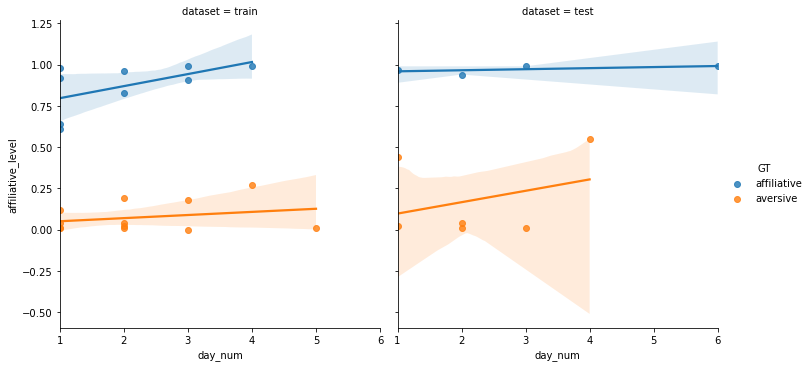

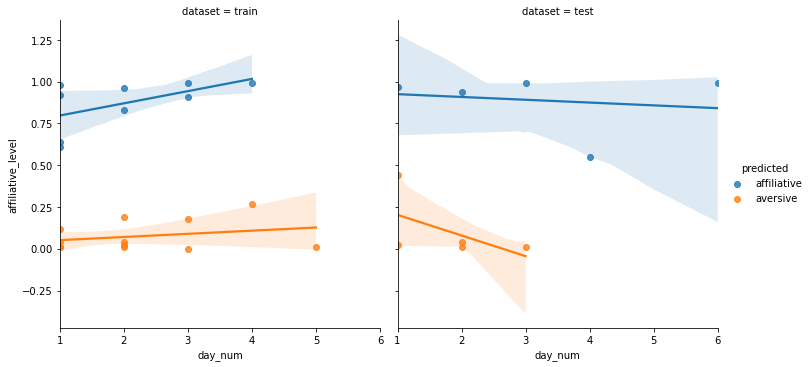

In [470]:
sns.lmplot(data=df_results_all, x='day_num', y='affiliative_level', hue='GT', col='dataset')
sns.lmplot(data=df_results_all, x='day_num', y='affiliative_level', hue='predicted', col='dataset')


## Dimensionality reduction using t-SNE and visualization|

In [351]:
# # create the figure and axes
# fig, ax = plt.subplots(figsize=(6, 6))

# # add the plots for each dataframe
# df_rats = df_results_all.groupby('rat_num')
# for ratnum , df_r in df_rats:
#     sns.regplot(x='day_num', y='affiliative_level', data=df_r, fit_reg=True, ci=None, ax=ax, label=ratnum)
# ax.set(ylabel='affiliative_level', xlabel='rat_num')
# ax.legend()
# plt.show()

In [471]:
col_names = df_train.drop(['sociability','dataset'], axis = 1).columns

### Test data

In [472]:
def plot_pairplot(title, X,y,y_pred):
    df_X = pd.DataFrame(X)


    df_X = df_X.rename(columns={num:cname for num, cname in enumerate(col_names)})
    df_X['GT'] = y
    df_X['predicted'] = y_pred
    df_X['correct'] = df_X['predicted'] == df_X['GT']

    g = sns.pairplot(data=df_X.drop(['predicted','correct'], axis=1), hue='GT')
    g.fig.suptitle(f"{title} Data GT sociability", y=1.05)

    g = sns.pairplot(data=df_X.drop(['GT','correct'], axis=1), hue='predicted')
    g.fig.suptitle(f"{title} Data GT predicted", y=1.05)
    

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


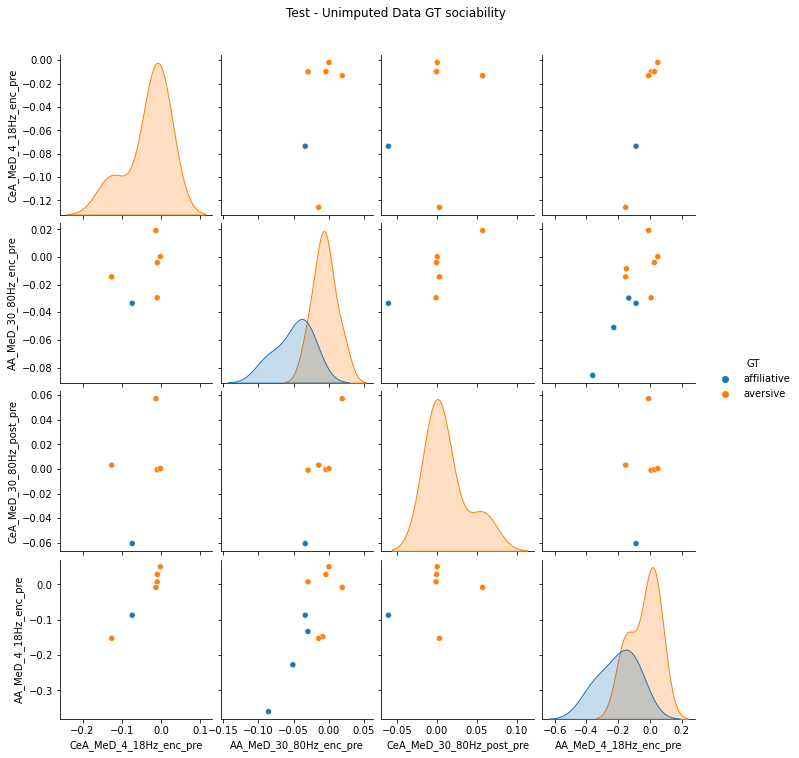

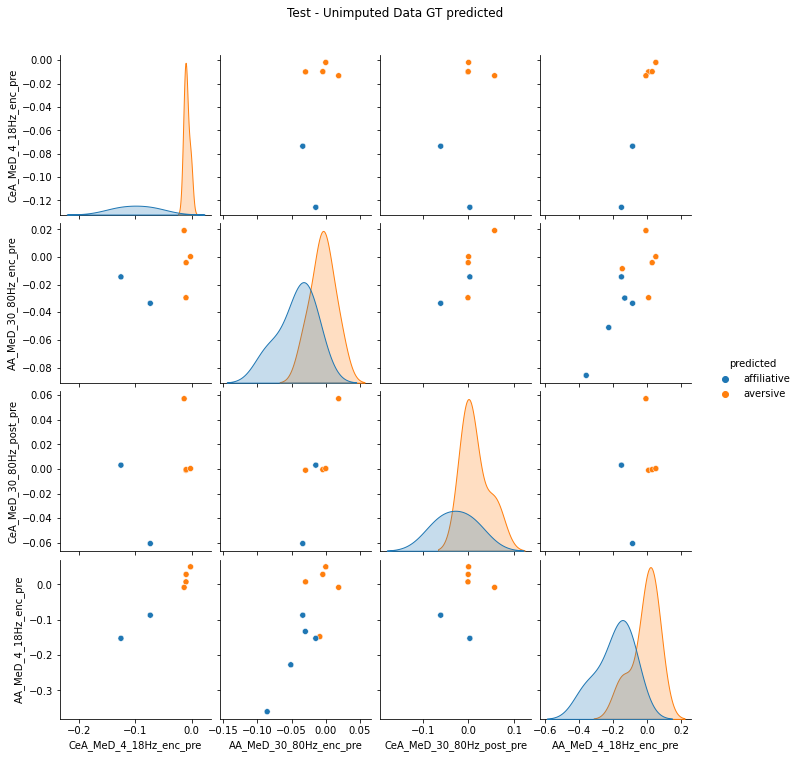

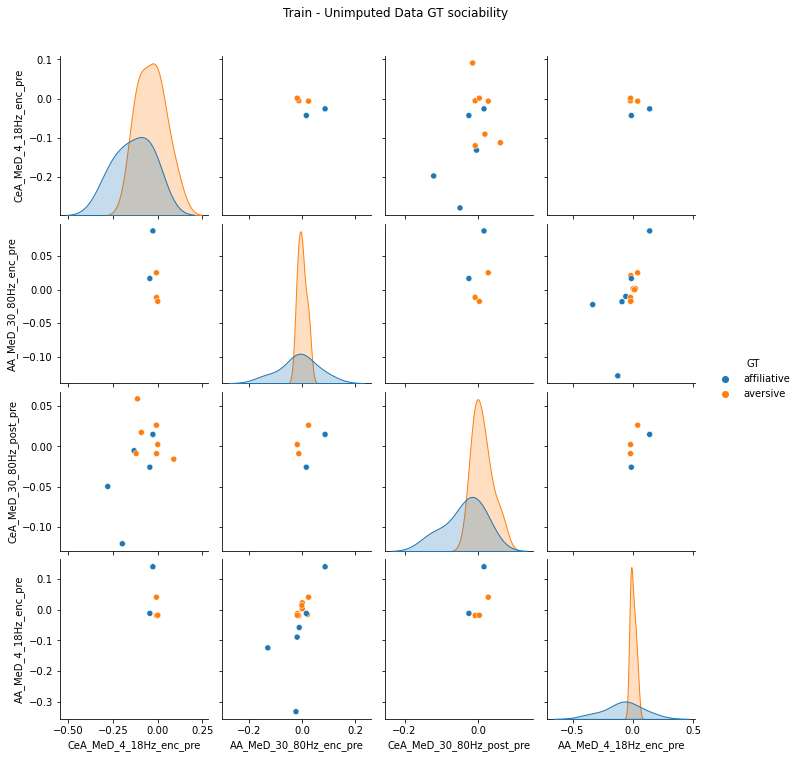

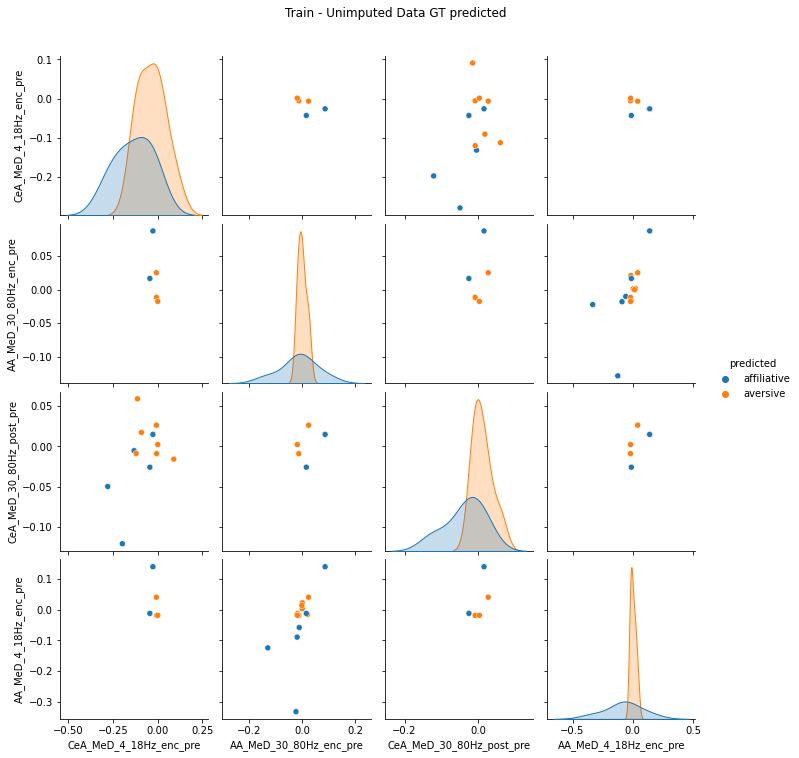

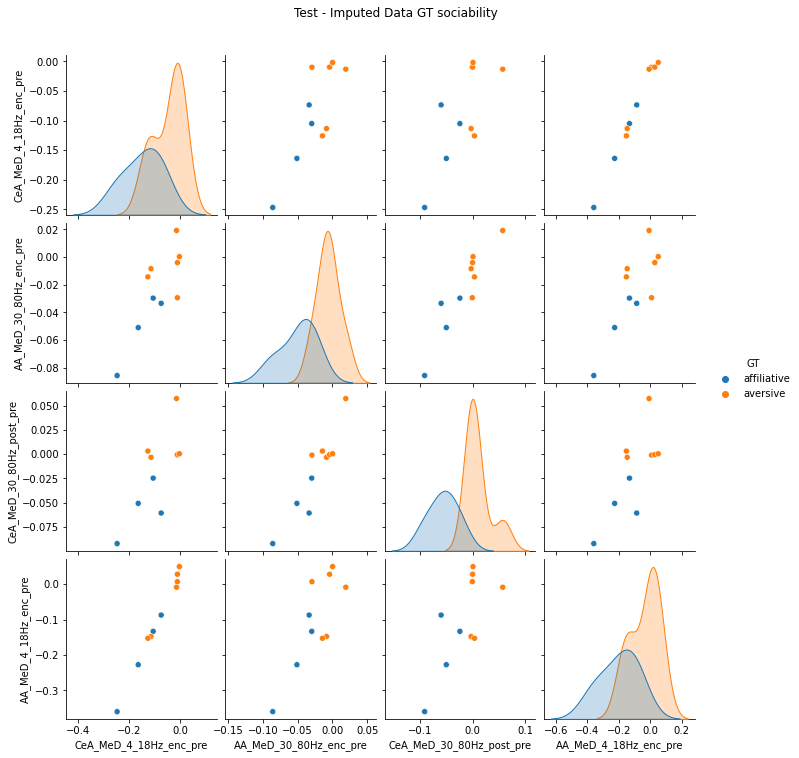

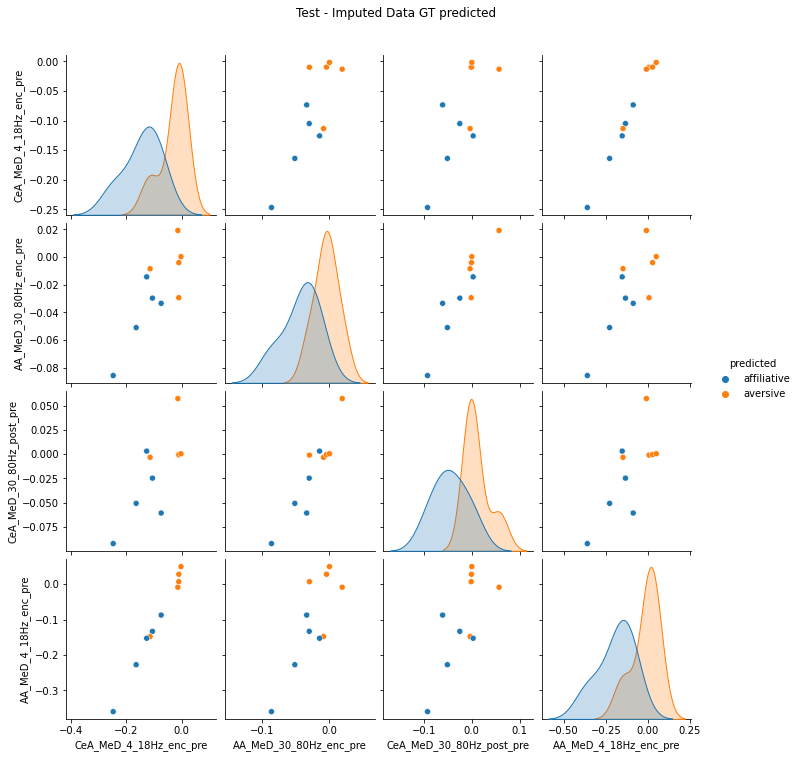

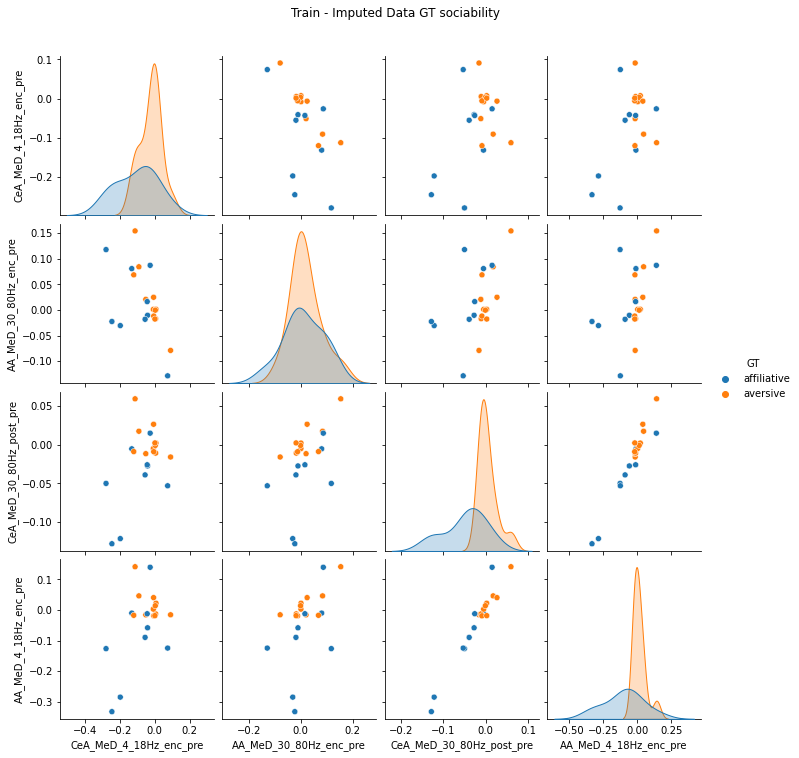

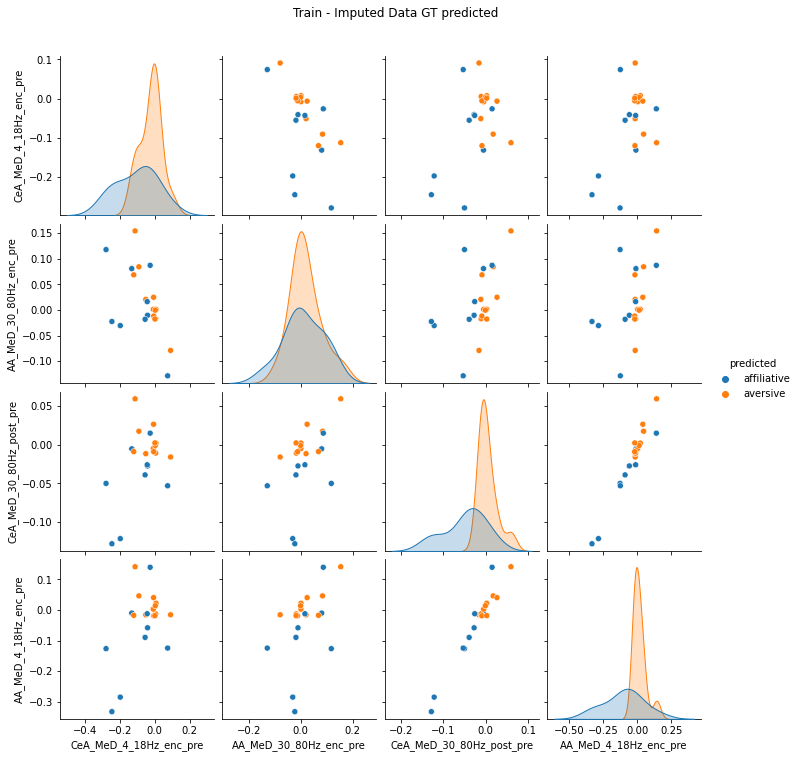

In [473]:

X = X_test
y = y_test.values
y_pred = y_test_pred
title = 'Test - Unimputed'
plot_pairplot(title, X,y,y_pred)


X = X_train
y = y_train.values
y_pred = y_train_pred
title = 'Train - Unimputed'
plot_pairplot(title, X,y,y_pred)

X = X_test_imp
y = y_test.values
y_pred = y_test_pred
title = 'Test - Imputed'
plot_pairplot(title, X,y,y_pred)

X = X_train_imp
y = y_train.values
y_pred = y_train_pred
title = 'Train - Imputed'
plot_pairplot(title, X,y,y_pred)


In [474]:
df_results_test

,files,GT,predicted,correct,confidence,affiliative_level,dataset
0,chamber_Rat19-probe18-Day2-Behavior_and_Optoge...,affiliative,affiliative,True,0.94,0.94,test
1,chamber_Rat19-Probe18-day3-Behavior_and_Optoge...,affiliative,affiliative,True,0.99,0.99,test
2,chamber_Rat19-probe18-day6-Behavior_and_Optoge...,affiliative,affiliative,True,0.99,0.99,test
3,chamber_Rat19-Probe18-day1-Behavior_and_Optoge...,aversive,aversive,True,0.56,0.44,test
4,chamber_Rat20-Probe19-day1-Behavior_and_Optoge...,affiliative,affiliative,True,0.97,0.97,test
5,chamber_Rat10-probe13-day1_Behavior_and_Optoge...,aversive,aversive,True,0.98,0.02,test
6,chamber_Rat10-probe13-day2_Behavior_and_Optoge...,aversive,aversive,True,0.99,0.01,test
7,chamber_Rat10-probe13-day3_Behavior_and_Optoge...,aversive,aversive,True,0.99,0.01,test
8,chamber_Rat10-probe13-day4_Behavior_and_Optoge...,aversive,affiliative,False,0.55,0.55,test
9,chamber_Rat12-probe16-day2_Behavior_and_Optoge...,aversive,aversive,True,0.96,0.04,test


In [475]:
df_results_test.columns

Index(['files', 'GT', 'predicted', 'correct', 'confidence',
       'affiliative_level', 'dataset'],
      dtype='object')

In [476]:
from sklearn.manifold import TSNE
from scipy.special import logit

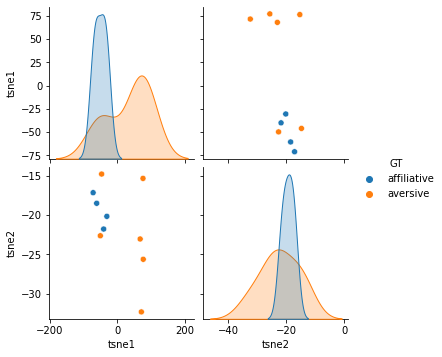

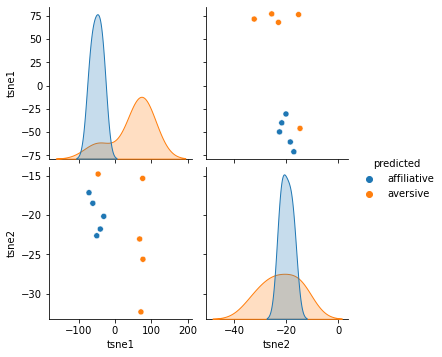

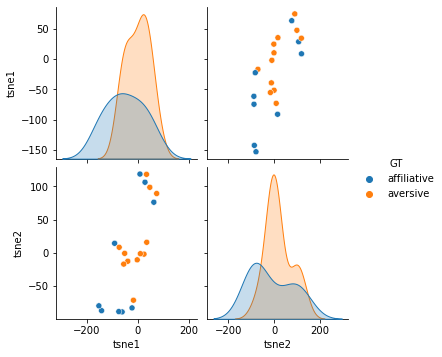

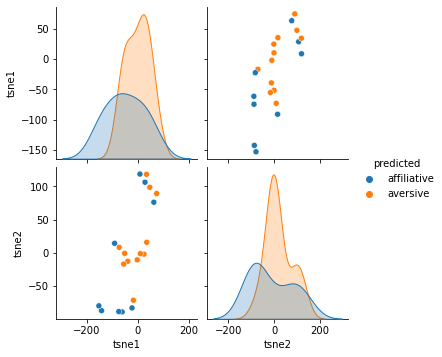

In [477]:
X = X_test_imp

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)

df_results_test[['tsne1','tsne2']] = X_embedded
sns.pairplot(df_results_test[['GT','tsne1','tsne2']], hue='GT')
sns.pairplot(df_results_test[['predicted','tsne1','tsne2']], hue='predicted')


X = X_train_imp

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)

df_results_train[['tsne1','tsne2']] = X_embedded
sns.pairplot(df_results_train[['GT','tsne1','tsne2']], hue='GT')
sns.pairplot(df_results_train[['predicted','tsne1','tsne2']], hue='predicted')

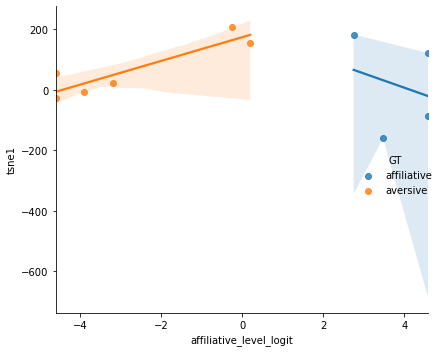

In [478]:


X = X_test_imp

X_embedded = TSNE(n_components=1, learning_rate='auto',
                  init='random', perplexity=2).fit_transform(X)

# df_results_test[['tsne1','tsne2']] = X_embedded
# sns.pairplot(df_results_test[['GT','tsne1','tsne2']], hue='GT')
# sns.pairplot(df_results_test[['predicted','tsne1','tsne2']], hue='predicted')

df_results_test[['tsne1']] = X_embedded
df_results_test['affiliative_level_logit'] = df_results_test['affiliative_level'].apply(logit)
sns.lmplot(data=df_results_test, x = 'affiliative_level_logit' ,y = 'tsne1', hue='GT')





# Display the plots
plt.tight_layout()
plt.show()


In [479]:
X = X_train_imp

X_embedded = TSNE(n_components=1, learning_rate='auto',
                  init='random', perplexity=1).fit_transform(X)

# df_results_test[['tsne1','tsne2']] = X_embedded
# sns.pairplot(df_results_test[['GT','tsne1','tsne2']], hue='GT')
# sns.pairplot(df_results_test[['predicted','tsne1','tsne2']], hue='predicted')

df_results_train[['tsne1']] = X_embedded
df_results_train['affiliative_level_logit'] = df_results_train['affiliative_level'].apply(logit)
sns.(data=df_results_train, x = 'affiliative_level_logit' ,y = 'tsne1', hue='GT')




# Display the plots
plt.tight_layout()
plt.show()

SyntaxError: invalid syntax (<ipython-input-479-8ccd9ebeb52d>, line 12)

In [ ]:
X = X_train_imp
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)

df_results_train[['tsne1','tsne2']] = X_embedded

sns.pairplot(df_results_train[['GT','tsne1','tsne2']], hue='GT')

sns.pairplot(df_results_train[['predicted','tsne1','tsne2']], hue='predicted')

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
# All data (train and test)


X = np.append(X_train_imp, X_test_imp, axis=0)
y = np.append(y_train, y_test)
y_pred = np.append(y_train_pred, y_test_pred)

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=10, n_iter=5000).fit_transform(X)


df_res_tsne = pd.DataFrame(y, columns=['GT'])
df_res_tsne['dataset'] = np.append(np.full(y_train.shape, "train"), np.full(y_test.shape, "test"))
df_res_tsne['predicted'] = y_pred
df_res_tsne['correct'] = df_res_tsne['predicted'] == df_res_tsne['GT']
df_res_tsne[['tsne1','tsne2']] = X_embedded
#Seaborn pair plot

sns.pairplot(df_res_tsne[['GT','tsne1','tsne2']], hue='GT')

sns.pairplot(df_res_tsne[['predicted','tsne1','tsne2']], hue='predicted')

# # Display the plots
# plt.tight_layout()
# plt.show()

In [ ]:
df_res_tsne.head(1)

### Impute the missing values of all the dataset before training and testing

Performing imputation before splitting the dataset can potentially lead to data leakage and overly optimistic evaluation results. It's generally recommended to split the dataset into training and testing sets before applying any data preprocessing steps, including imputation.

Data leakage can occur when information from the testing set is inadvertently used during the imputation process. This can lead to overfitting and unrealistic evaluation results because the imputation is informed by the target variable in the testing set.

In [139]:
# imputer = IterativeImputer(max_iter=100)
imputer_class = MissForest

# model_class = RandomForestClassifier
# model = LogisticRegression(max_iter=10000)
# model_class = svm.SVC
model_class = tree.DecisionTreeClassifier

In [149]:
data = data.drop('0', axis=1)

In [150]:
# Impute data before splitting it into train and test

imputer = imputer_class()
model = model_class()

imputed_data = imputer.fit_transform(data)

# Splitting the imputed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(imputed_data,
                                                    labels,
                                                    test_size=0.3,
                                                    stratify=labels)


# Creating and training the model (using Logistic Regression as an example)


model.fit(X_train, y_train)


# Making predictions on the training and testing sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


# Calculating accuracy scores
# train_accuracy = accuracy_score(y_train.values, y_train_pred)
# test_accuracy = accuracy_score(y_test.values, y_test_pred)
ret_test = eval_model(y_test, y_test_pred)
ret_train = eval_model(y_train, y_train_pred)



df_results_test = pd.DataFrame(y_test, columns={'GT'})
df_results_test['predicted'] = y_test_pred
df_results_test['correct'] = df_results_test['GT'] == df_results_test['predicted']
print(df_results_test)


print('Test')
[print(f'{metric}:{values}') for metric, values in ret_test.items()]
print('Train')
[print(f'{metric}:{values}') for metric, values in ret_train.items()]


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 0


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 1


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 2


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 3


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 4
            GT    predicted  correct
0  affiliative  affiliative     True
1     aversive     aversive     True
2     aversive  affiliative    False
3     aversive     aversive     True
4     aversive     aversive     True
5     aversive     aversive     True
6     aversive     aversive     True
7  affiliative  affiliative     True
8  affiliative  affiliative     True
9  affiliative     aversive    False
Test
accuracy:0.8
precision:0.75
recall:0.75
f1:0.75
Train
accuracy:1.0
precision:1.0
recall:1.0
f1:1.0


[None, None, None, None]

### Imputing the data after each splitting

The imputaion quality drops when performing on smaller sub sets

In [151]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import accuracy_score



# Splitting the imputed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    labels,
                                                    test_size=0.3,
                                                    stratify=labels)

imputer = imputer_class()
model = model_class()

imputed_data_train = imputer.fit_transform(X_train)
imputed_data_test = imputer.fit_transform(X_test)

# Converting the imputed data back to a DataFrame
imputed_data_train = pd.DataFrame(imputed_data_train, columns=X_train.columns)
imputed_data_test = pd.DataFrame(imputed_data_test, columns=X_test.columns)



# Creating and training the model (using Logistic Regression as an example)
# model = LogisticRegression()
model.fit(imputed_data_train, y_train)

# Making predictions on the training and testing sets
y_train_pred = model.predict(imputed_data_train)
y_test_pred = model.predict(imputed_data_test)

# Calculating accuracy scores
# train_accuracy = accuracy_score(y_train.values, y_train_pred)
# test_accuracy = accuracy_score(y_test.values, y_test_pred)
ret_test = eval_model(y_test, y_test_pred)
ret_train = eval_model(y_train, y_train_pred)


df_results_test = pd.DataFrame(y_test, columns={'GT'})
df_results_test['predicted'] = y_test_pred
df_results_test['correct'] = df_results_test['GT'] == df_results_test['predicted']
print(df_results_test)




print('Test')
[print(f'{metric}:{values}') for metric, values in ret_test.items()]
print('Train')
[print(f'{metric}:{values}') for metric, values in ret_train.items()]



C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 0


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 1


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 0


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 1
            GT    predicted  correct
0     aversive  affiliative    False
1  affiliative     aversive    False
2     aversive     aversive     True
3     aversive     aversive     True
4  affiliative  affiliative     True
5     aversive  affiliative    False
6     aversive     aversive     True
7  affiliative  affiliative     True
8  affiliative  affiliative     True
9     aversive     aversive     True
Test
accuracy:0.7
precision:0.6
recall:0.75
f1:0.667
Train
accuracy:1.0
precision:1.0
recall:1.0
f1:1.0


[None, None, None, None]

### Cross validation
Since the data plitting have significant effect on the model performance, cross validation is important

In [152]:
def one_fold(X_train, X_test, y_train, y_test):
        # Splitting the imputed data into training and testing sets


    imputer = imputer_class(max_iter=500)
    model = model_class()
    
    imputed_data_train = imputer.fit_transform(X_train)
    imputed_data_test = imputer.fit_transform(X_test)

    # Converting the imputed data back to a DataFrame
#     imputed_data_train = pd.DataFrame(imputed_data_train, columns=X_train.columns)
#     imputed_data_test = pd.DataFrame(imputed_data_test, columns=X_test.columns)
    
    # debug
#     print(imputed_data_test.shape)
#     print(imputed_data_test.shape)


    # Creating and training the model (using Logistic Regression as an example)
    
    model.fit(imputed_data_train, y_train)

    # Making predictions on the training and testing sets
    y_train_pred = model.predict(imputed_data_train)
    y_test_pred = model.predict(imputed_data_test)
    
    return y_train, y_train_pred, y_test, y_test_pred

In [153]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold

# Define the cross-validation strategy
cv = KFold(n_splits=3, shuffle=True)
# cv = StratifiedKFold(n_splits=2, shuffle=True)

cv_scores_train = []
cv_scores_test = []
# for train_index, test_index in cv.split(data, rat_numbers):
for train_index, test_index in cv.split(data):
    X_train, X_test = data.iloc[train_index], data.iloc[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    y_train, y_train_pred, y_test, y_test_pred = one_fold(X_train, X_test, y_train, y_test)
    scores_train = eval_model(y_train, y_train_pred)
    scores_test = eval_model(y_test, y_test_pred)
    cv_scores_train.append(scores_train)
    cv_scores_test.append(scores_test)
# Summarize
ret_train = pd.DataFrame(cv_scores_train).mean()
ret_test = pd.DataFrame(cv_scores_test).mean()






C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 0


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 1


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 0


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 1


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 0


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 1


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 2


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 3


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 4


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 5


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 0


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 1


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 0


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 1


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 2


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 3


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 4


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 0


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 1


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 2


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 3


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 4


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 5
Iteration: 6


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [154]:
print('Test')
print(ret_test)

print('Train')
print(ret_train)

# print('Test')
# [[print(f'{metric}:{values}') for metric, values in ret.items()] for ret in cv_scores_test]
# print('Train')
# [[print(f'{metric}:{values}') for metric, values in ret.items()] for ret in cv_scores_train]


Test
accuracy     0.612000
precision    0.652000
recall       0.583333
f1           0.519333
dtype: float64
Train
accuracy     1.0
precision    1.0
recall       1.0
f1           1.0
dtype: float64


In [155]:
 pd.DataFrame(cv_scores_test)

,accuracy,precision,recall,f1
0,0.636,0.556,1.00,0.714
1,0.500,0.400,0.50,0.444
2,0.700,1.000,0.25,0.400


### Impute the data and see how it looks

In [156]:
imputer = imputer_class(1000)
imputed_data = imputer.fit_transform(data)

C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 0


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 1


In [159]:
labels_num = np.array(labels=='affiliative', dtype=float)*0.1
labels_num = labels_num[:, np.newaxis]

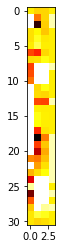

In [160]:

data_conc = np.concatenate((data.values, labels_num), axis=1)
plt.imshow(data_conc, cmap='hot', interpolation='nearest')
plt.show()

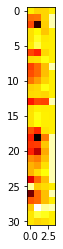

In [161]:
imputed_data_concat = np.concatenate((imputed_data, labels_num), axis=1)
plt.imshow(imputed_data_concat, cmap='hot', interpolation='nearest')
plt.show()


In [162]:
from sklearn.manifold import TSNE
X = imputed_data
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=15).fit_transform(X)
X_embedded.shape

(31, 2)

In [164]:
from sklearn.preprocessing import LabelEncoder

strings = filenames
label_encoder = LabelEncoder()
converted_numbers = label_encoder.fit_transform(strings)

strings = filenames
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(labels)

converted_numbers


rat_numbers = [extract_ratnum_from_file_name(filename) for filename in filenames]


In [165]:
df_tsne = pd.DataFrame(X_embedded)

df_tsne['labels'] = labels
df_tsne['filenames'] = converted_numbers
df_tsne['rat_number'] = rat_numbers
# df_tsne['pred'] = 


In [166]:
# get the dummies and store it in a variable
dummies = pd.get_dummies(df_tsne.labels)
 
# Concatenate the dummies to original dataframe
merged = pd.concat([df_tsne, dummies], axis='columns')
 
# drop the values
merged.drop(['labels'], axis='columns')

merged = merged[['rat_number','affiliative','aversive']].groupby('rat_number').sum()
merged['sum'] = merged['affiliative'] + merged['aversive']
merged

,affiliative,aversive,sum
rat_number,,,
3,2,2,4
4,1,2,3
10,0,4,4
12,0,1,1
15,1,2,3
16,1,2,3
17,0,3,3
19,3,1,4
20,1,0,1


<AxesSubplot:xlabel='0', ylabel='1'>

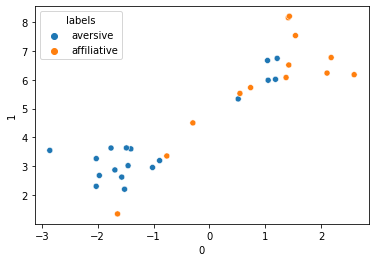

In [167]:
sns.scatterplot(data=df_tsne, x=0, y=1, hue='labels')

In [169]:
# sns.catplot(data=df_tsne, x=0, y=1, hue='rat_number', row='labels')

In [170]:
# sns.catplot(data=df_tsne, x=0, y=1, hue='filenames', row='labels')

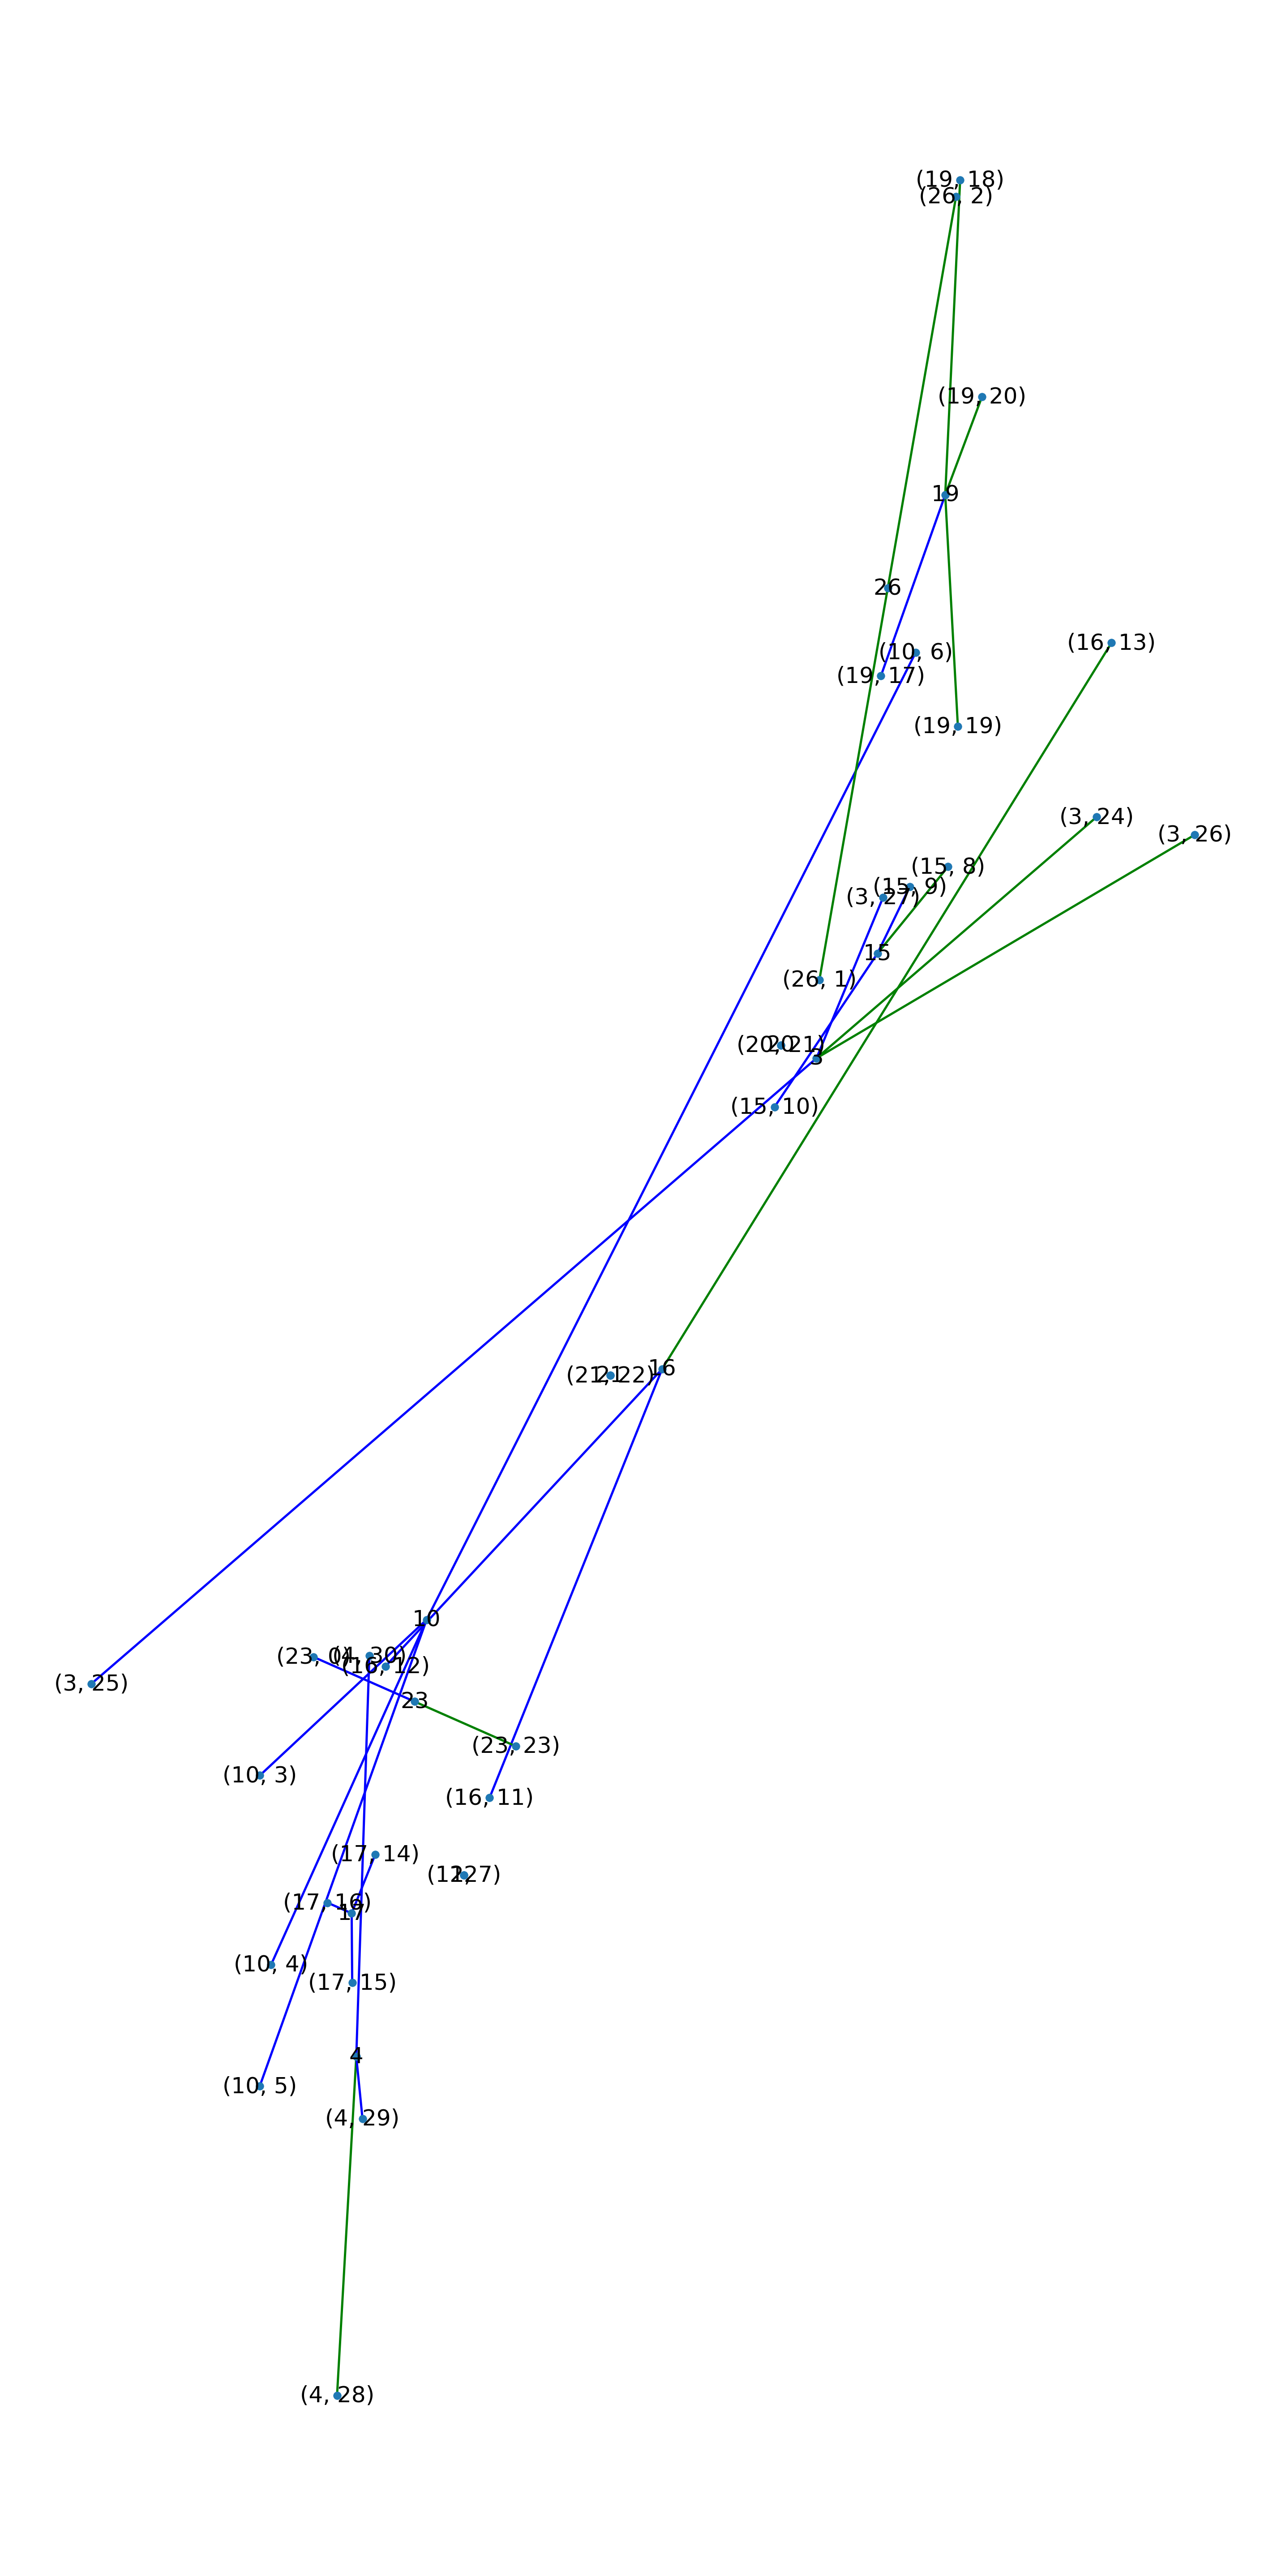

In [172]:
G = nx.Graph()
all_pos = {}
colors = []
for r, df_r in df_tsne.groupby('rat_number'):


    f_names = df_r['filenames'].values
    pos_ = df_r[[0,1]].values
    pos_2 = {(r,f): p for p, f in zip(pos_,f_names)}
    mean_pos = np.mean(pos_,axis=0)
    pos_2[r] = mean_pos
    
    labels_sub = np.array(['b']* len(df_r))
    labels_sub[np.where(np.array(df_r['labels']=='affiliative'))] = 'g'
    
    all_pos.update(pos_2)
    [G.add_edge(r, (r,f)) for f in f_names]
    colors = np.append(colors, labels_sub)
# colors = np.array(colors).flatten()
fig = plt.figure(figsize=(40,80))
# nx.draw_networkx(G,all_pos)
nx.draw_networkx(G,all_pos, edge_color=colors, font_size=50,width=5)
ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [175]:
# G = nx.Graph()
# all_pos = {}
# df_g = df_tsne.groupby('rat_number')
# n_groups = len(df_g)
# fig = plt.figure(figsize=(40,80))
# for n, (r, df_r) in enumerate(df_g):
#     G = nx.Graph()
#     plt.subplot(n_groups,1,n+1)

#     f_names = df_r['filenames'].values
#     pos_ = df_r[[0,1]].values
#     labels_sub = np.array(['b']* len(df_r))
#     labels_sub[np.where(np.array(df_r['labels']=='affiliative'))] = 'g'
# #     labels_sub = np.append(labels_sub, 'y', axis=None)
    
    
#     pos_2 = {(r,f): p for p, f in zip(pos_,f_names)}
#     mean_pos = np.mean(pos_,axis=0)
    
#     pos_2[r] = mean_pos
    
#     all_pos.update(pos_2)
#     [G.add_edge(r, (r,f)) for f in f_names]
    

#     nx.draw_networkx(G,pos_2, node_size=2000, font_size=50, edge_color=labels_sub)
#     ax = plt.gca()
#     ax.margins(0.08)
# #     plt.axis("off")
#     plt.tight_layout()
# plt.show()